<a href="https://colab.research.google.com/github/Hriday1001/Braille_Character_Recognition/blob/main/BrailleOpenCV_character.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from zipfile import ZipFile
file_name = "/content/archive.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [2]:
from copy import deepcopy
import os
import numpy as np
import pandas as pd
from shutil import copyfile

In [3]:
os.mkdir('./images/')
alpha = 'a'
for i in range(0, 26): 
	os.mkdir('./images/' + alpha)
	alpha = chr(ord(alpha) + 1)

In [4]:
rootdir = '/content/Braille Dataset/Braille Dataset/'
for file in os.walk(rootdir):
  for ind_file in file[2]:
    ind_file_string = ''.join(str(elm) for elm in ind_file)
    path = (rootdir + ind_file_string)
    letter = ind_file[0]
    file_string = ''.join(str(element) for element in file[2])
    copyfile(path,('/content/images/' + letter + '/' + ind_file_string))

In [5]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=20,
                             shear_range=10,
                             validation_split=0.2)

train_generator = datagen.flow_from_directory('./images/',
                                              target_size=(26,26),
                                              subset='training')

val_generator = datagen.flow_from_directory('./images/',
                                            target_size=(26,26),
                                            subset='validation')

Found 1248 images belonging to 26 classes.
Found 312 images belonging to 26 classes.


In [6]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

K.clear_session()

model_ckpt = ModelCheckpoint('BrailleNet.h5',save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=8,verbose=0)
early_stop = EarlyStopping(patience=15,verbose=1)

entry = L.Input(shape=(26,26,3))
x = L.SeparableConv2D(64,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(128,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(256,(2,2),activation='relu')(x)
x = L.GlobalMaxPooling2D()(x)
x = L.Dense(256)(x)
x = L.LeakyReLU()(x)
x = L.Dense(64,kernel_regularizer=l2(2e-4))(x)
x = L.LeakyReLU()(x)
x = L.Dense(26,activation='softmax')(x)

model = Model(entry,x)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              validation_data=val_generator,
                              epochs=500,
                              callbacks=[model_ckpt,reduce_lr,early_stop],
                              verbose=1)

<ipython-input-6-281ab1c5ae10>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/500
39/39 [==============================] - 5s 84ms/step - loss: 3.2824 - accuracy: 0.0401 - val_loss: 3.2624 - val_accuracy: 0.1026 - lr: 0.0010
Epoch 2/500
39/39 [==============================] - 4s 102ms/step - loss: 3.2123 - accuracy: 0.0689 - val_loss: 3.0421 - val_accuracy: 0.1282 - lr: 0.0010
Epoch 3/500
39/39 [==============================] - 3s 65ms/step - loss: 2.8275 - accuracy: 0.1587 - val_loss: 2.5504 - val_accuracy: 0.2308 - lr: 0.0010
Epoch 4/500
39/39 [==============================] - 3s 74ms/step - loss: 2.5002 - accuracy: 0.2692 - val_loss: 2.1987 - val_accuracy: 0.3718 - lr: 0.0010
Epoch 5/500
39/39 [==============================] - 3s 66ms/step - loss: 2.0625 - accuracy: 0.4199 - val_loss: 1.9052 - val_accuracy: 0.4744 - lr: 0.0010
Epoch 6/500
39/39 [==============================] - 3s 85ms/step - loss: 1.6342 - accuracy: 0.5168 - val_loss: 1.4857 - val_accuracy: 0.5353 - lr: 0.0010
Epoch 7/500
39/39 [==============================] - 3s 74ms/step - l

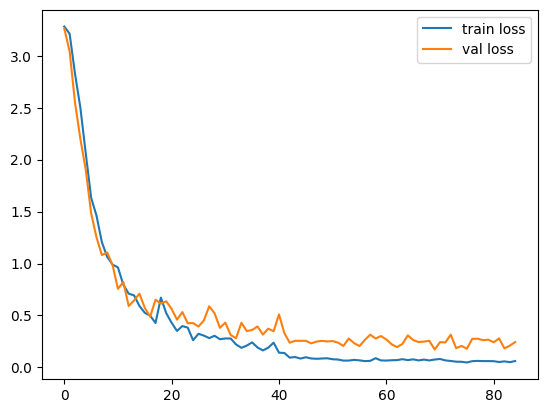

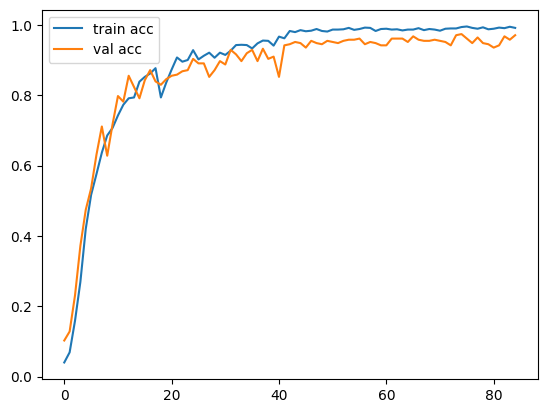

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [8]:
from tensorflow.keras.preprocessing import image
img = image.load_img("/content/character_p.png")

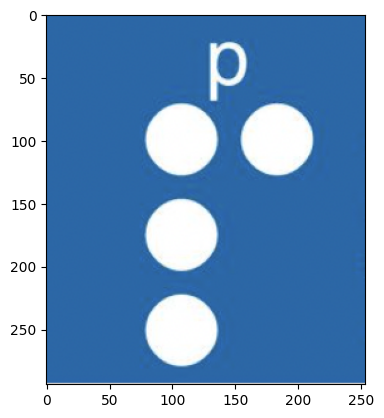

In [13]:
plt.imshow(img)


In [ ]:
from tensorflow.keras.utils import img_to_array
x = img_to_array(img)
x

In [28]:
x.shape

(294, 254, 3)

In [33]:
import cv2
resized = cv2.resize(x, (26, 26))

In [34]:
resized.shape

(26, 26, 3)

In [36]:
resized=np.expand_dims(resized,axis=0)
model.predict(resized)

1/1 [==============================] - 0s 112ms/step


array([[0.0000000e+00, 3.7828487e-15, 0.0000000e+00, 2.0263174e-25,
        0.0000000e+00, 2.0537173e-14, 1.4536504e-18, 1.2673387e-28,
        0.0000000e+00, 1.8177640e-19, 0.0000000e+00, 5.6658342e-07,
        0.0000000e+00, 1.6888807e-37, 0.0000000e+00, 5.1072341e-11,
        8.0003792e-01, 6.9866245e-14, 6.7704134e-30, 5.3022912e-08,
        0.0000000e+00, 2.3017959e-07, 1.9996122e-01, 0.0000000e+00,
        2.0552630e-16, 0.0000000e+00]], dtype=float32)

In [37]:
a=np.argmax(model.predict(resized), axis=1)
a

1/1 [==============================] - 0s 37ms/step


array([16])

In [42]:
letter = chr(a[0] + ord('a') - 1)
print(letter)

p
